In [ ]:
import numpy as np
import pandas as pd
import nltk
from sklearn.model_selection import train_test_split
import nltk
import string
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import SnowballStemmer
nltk.download('punkt')
nltk.download('stopwords')
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import precision_score, recall_score, precision_recall_curve
from matplotlib import pyplot as plt
from sklearn.metrics import plot_precision_recall_curve
from sklearn.model_selection import GridSearchCV

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
# labeled.csv находится в папке data 
# Sep у нас запятая

df = pd.read_csv('./data/labeled.csv', sep=",")

Проведём анализ данных

In [ ]:
# Оценим общий размер данных

df.shape

(14412, 2)

In [ ]:
# Оценим распределение данных
# Сколько токсичных комментариев и нейтральных

df['toxic'].value_counts()

0.0    9586
1.0    4826
Name: toxic, dtype: int64

In [ ]:
# Выведем первые 10 строк

df.head(10)

,comment,toxic
0,"Верблюдов-то за что? Дебилы, бл...\n",1.0
1,"Хохлы, это отдушина затюканого россиянина, мол...",1.0
2,Собаке - собачья смерть\n,1.0
3,"Страницу обнови, дебил. Это тоже не оскорблени...",1.0
4,"тебя не убедил 6-страничный пдф в том, что Скр...",1.0
5,Для каких стан является эталоном современная с...,1.0
6,В шапке были ссылки на инфу по текущему фильму...,0.0
7,УПАД Т! ТАМ НЕЛЬЗЯ СТРОИТЬ! ТЕХНОЛОГИЙ НЕТ! РА...,1.0
8,"Ебать тебя разносит, шизик.\n",1.0
9,"Обосрался, сиди обтекай\n",1.0


In [ ]:
# Переведём 'toxic' из float в int

df['toxic'] = df['toxic'].apply(int)

In [ ]:
# Возьмём 500 сэмплов в тест

train_df, test_df = train_test_split(df, test_size = 500)

In [ ]:
# Проверим распределение в тесте и трэйне

test_df['toxic'].value_counts()

0    365
1    135
Name: toxic, dtype: int64

In [ ]:
train_df['toxic'].value_counts()

0    9221
1    4691
Name: toxic, dtype: int64

 Воспользуемся логистической регрессией с sklearn

In [ ]:
# Разделим предложения на токены:
# Возьмём пример и вызовем word_tokenize
# С помощью string удалим знаки пунктуации
# Получаем и удаляем стоп-слова
# К оставшимся словам применяем стемминг


sentence_example = df.iloc[1]["comment"]
tokens = word_tokenize(sentence_example, language="russian")
tokens_without_punctuation = [i for i in tokens if i not in string.punctuation]
russian_stop_words = stopwords.words("russian")
tokens_without_stop_words_and_punctuation = [i for i in tokens_without_punctuation if i not in russian_stop_words]
snowball = SnowballStemmer(language="russian")
stemmed_tokens = [snowball.stem(i) for i in tokens_without_stop_words_and_punctuation]

In [ ]:
# Проверим

tokenize_sentence(sentence_example)

['хохл',
 'эт',
 'отдушин',
 'затюкан',
 'россиянин',
 'мол',
 'вон',
 'хохл',
 'хуж',
 'есл',
 'хохл',
 'кисел',
 'придума']

In [ ]:
# Стеммер + стоп-слова 
# Повторяем процессы с предыдущего кода
# Можем удалить стоп-слова, если необходимо

snowball = SnowballStemmer(language="russian")
russian_stop_words = stopwords.words("russian")

def tokenize_sentence(sentence: str, remove_stop_words: bool = True):
    tokens = word_tokenize(sentence, language="russian")
    tokens = [i for i in tokens if i not in string.punctuation]
    if remove_stop_words:
        tokens = [i for i in tokens if i not in russian_stop_words]
    tokens = [snowball.stem(i) for i in tokens]
    return tokens


In [ ]:
# Проверим

tokenize_sentence(sentence_example)

['хохл',
 'эт',
 'отдушин',
 'затюкан',
 'россиянин',
 'мол',
 'вон',
 'хохл',
 'хуж',
 'есл',
 'хохл',
 'кисел',
 'придума']

In [ ]:
# TF-IDF векторизация
# Переопределяем токенайзер

vectorizer = TfidfVectorizer(tokenizer=lambda x: tokenize_sentence(x, remove_stop_words=True))

In [ ]:
# fit_transform обучить список предложений из тренировочного дс, потом вернёт как готовые фичи

features = vectorizer.fit_transform(train_df["comment"])

In [ ]:
# Теперь начнём обучать модель логистической регрессии

model = LogisticRegression(random_state=0)
model.fit(features, train_df["toxic"])

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=0, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [ ]:
# Проверим на тренировочном дс


model.predict(features[0])

array([1])

In [ ]:
# Токсичный
# Проверим самостоятельно

train_df.iloc[0]

comment    РРРРРРЯЯЯЯЯЯЯ РУССКИЕ ВАНЬКИ НИКОМУ НЕ НУЖНЫ!!...
toxic                                                      1
Name: 6350, dtype: object

In [ ]:
# Соединим фичи и модель с помощью pipeline

model_pipeline = Pipeline([
    ("vectorizer", TfidfVectorizer(tokenizer=lambda x: tokenize_sentence(x, remove_stop_words=True))),
    ("model", LogisticRegression(random_state=0))])

In [ ]:
# Теперь принимает предложения, а не вещественные вектора
# Передаём список предложений и лэйблы
# Это даст возможность передавать текст

model_pipeline.fit(train_df["comment"], train_df["toxic"])

Pipeline(memory=None,
         steps=[('vectorizer',
                 TfidfVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.float64'>,
                                 encoding='utf-8', input='content',
                                 lowercase=True, max_df=1.0, max_features=None,
                                 min_df=1, ngram_range=(1, 1), norm='l2',
                                 preprocessor=None, smooth_idf=True,
                                 stop_words=None, strip_accents=None,
                                 sublinear_tf=False,
                                 token_patt...)\\b\\w\\w+\\b',
                                 tokenizer=<function <lambda> at 0x7f3bc5a088c0>,
                                 use_idf=True, vocabulary=None)),
                ('model',
                 LogisticRegression(C=1.0, class_weight=None, dual=False,
                                    fi

In [ ]:
# Самостоятельно придумаем предложения и проверим
# Должно опознаться как токсичный
model_pipeline.predict(['Поздравляю! Ты -- сын собаки!'])

array([1])

In [ ]:
# Напишем нейтральный текст

model_pipeline.predict(['У таких как ты, всегда всё получается'])

array([0])

In [ ]:
# Измерим метрики precision и recall
# Ожидаемый результат >= 95%
# В случае несоответствия, будем менять precision и recall 

precision_score(y_true=test_df["toxic"], y_pred=model_pipeline.predict(test_df["comment"]))

0.8878504672897196

In [ ]:
recall_score(y_true=test_df["toxic"], y_pred=model_pipeline.predict(test_df["comment"]))

0.7037037037037037

Не оправдывает ожидания.
Посмотрим зависимость Precision и Recall

In [ ]:
prec, rec, thresholds = precision_recall_curve(y_true=test_df["toxic"], probas_pred=model_pipeline.predict_proba(test_df["comment"])[:, 1])

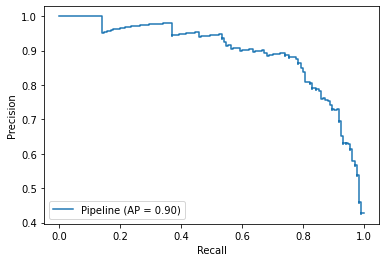

In [ ]:
plot_precision_recall_curve(estimator=model_pipeline, X=test_df["comment"], y=test_df["toxic"])

In [ ]:
# Ищем участок, где Precision > 95%
# Для этого воспользуемся np.where(prec > 95)

np.where(prec > 0.95)

(array([251, 252, 253, 254, 255, 264, 265, 266, 267, 268, 269, 270, 271,
        272, 273, 274, 275, 276, 277, 278, 279, 280, 281, 282, 283, 284,
        285, 286, 287, 288, 289, 290, 291, 292, 293, 294, 295, 297, 298,
        299, 300, 301, 302, 303, 304, 305, 306, 307, 308, 309, 310, 311,
        312, 313, 314, 315, 316]),)

In [ ]:
# Самый первый участок --  251. Им и воспользуемся.

thresholds[251]

0.6721618061042612

In [ ]:
# Оценим данный порог
# Посчитаем Precision, а далее Recall

precision_score(y_true=test_df["toxic"], y_pred=model_pipeline.predict_proba(test_df["comment"])[:, 1] > thresholds[251])

0.953125

In [ ]:
recall_score(y_true=test_df["toxic"], y_pred=model_pipeline.predict_proba(test_df["comment"])[:, 1] > thresholds[251])

0.45185185185185184

In [ ]:
# Подберём гиперпараметры, чтобы улучшить нашу модель.
# Через GridSearch найдём параметры, которые позволят получить лучшую метрику
# Обернём Лог.Регрессию в GridSearch
# param_grid -- переберём 3 параметра регул-ии. Во время кросс-валидации разобьём на 3 фолда(части)


grid_pipeline = Pipeline([
    ("vectorizer", TfidfVectorizer(tokenizer=lambda x: tokenize_sentence(x, remove_stop_words=True))),
    ("model", 
     GridSearchCV(
        LogisticRegression(random_state=0),
        param_grid={'C': [0.1, 1, 10.]},
        cv=3,
         verbose=4
        ))
    ])

In [ ]:
# Обучим

grid_pipeline.fit(train_df["comment"], train_df["toxic"])

Fitting 3 folds for each of 3 candidates, totalling 9 fits
[CV] C=0.1 ...........................................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] ............................... C=0.1, score=0.686, total=   0.4s
[CV] C=0.1 ...........................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.4s remaining:    0.0s


[CV] ............................... C=0.1, score=0.683, total=   0.4s
[CV] C=0.1 ...........................................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.8s remaining:    0.0s


[CV] ............................... C=0.1, score=0.685, total=   0.2s
[CV] C=1 .............................................................


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    1.1s remaining:    0.0s


[CV] ................................. C=1, score=0.838, total=   0.6s
[CV] C=1 .............................................................
[CV] ................................. C=1, score=0.833, total=   0.5s
[CV] C=1 .............................................................
[CV] ................................. C=1, score=0.840, total=   0.7s
[CV] C=10.0 ..........................................................


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


[CV] .............................. C=10.0, score=0.865, total=   1.0s
[CV] C=10.0 ..........................................................


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


[CV] .............................. C=10.0, score=0.867, total=   1.0s
[CV] C=10.0 ..........................................................


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:    6.0s finished


[CV] .............................. C=10.0, score=0.863, total=   1.1s


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


Pipeline(memory=None,
         steps=[('vectorizer',
                 TfidfVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.float64'>,
                                 encoding='utf-8', input='content',
                                 lowercase=True, max_df=1.0, max_features=None,
                                 min_df=1, ngram_range=(1, 1), norm='l2',
                                 preprocessor=None, smooth_idf=True,
                                 stop_words=None, strip_accents=None,
                                 sublinear_tf=False,
                                 token_patt...
                                                           class_weight=None,
                                                           dual=False,
                                                           fit_intercept=True,
                                                           intercept_scali

In [ ]:
# Модель не сошлась, но попробуем обучить, используя коэф.регул-ции C=10 
# ^ C=10 -- лучший результат


c_10_model_pipeline = Pipeline([
    ("vectorizer", TfidfVectorizer(tokenizer=lambda x: tokenize_sentence(x, remove_stop_words=True))),
    ("model", LogisticRegression(random_state=0, C=10))]
)

In [ ]:
# Модель не сошлась, но попробуем обучить, используя коэф.регул-ции C=10 
# ^ C=10 -- лучший результат

c_10_model_pipeline.fit(train_df["comment"], train_df["toxic"])

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


Pipeline(memory=None,
         steps=[('vectorizer',
                 TfidfVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.float64'>,
                                 encoding='utf-8', input='content',
                                 lowercase=True, max_df=1.0, max_features=None,
                                 min_df=1, ngram_range=(1, 1), norm='l2',
                                 preprocessor=None, smooth_idf=True,
                                 stop_words=None, strip_accents=None,
                                 sublinear_tf=False,
                                 token_patt...u)\\b\\w\\w+\\b',
                                 tokenizer=<function <lambda> at 0x7f3bc5a6c710>,
                                 use_idf=True, vocabulary=None)),
                ('model',
                 LogisticRegression(C=10, class_weight=None, dual=False,
                                    fi

In [ ]:
# Посчитаем Precision и Recall для C=10

c_10_prec, c_10_rec, c_10_thresholds = precision_recall_curve(y_true=test_df["toxic"], probas_pred = c_10_model_pipeline.predict_proba(test_df["comment"])[:, 1])

In [ ]:
# Найдём, где Precision от C=10 > 95%

np.where(c_10_prec > 0.95)

(array([270, 271, 272, 273, 274, 275, 276, 277, 278, 279, 280, 281, 282,
        283, 284, 285, 286, 287, 288, 289, 290, 291, 292, 293, 294, 295,
        296, 297, 298, 299, 300, 301, 302, 303, 304, 305, 306, 307, 308,
        309, 310, 311, 312, 313, 314, 315, 316, 317, 318, 319, 320, 321,
        322, 323, 324, 325, 326, 327, 328, 329, 330, 331, 332, 333, 334,
        335, 336, 337, 338, 339, 340, 341]),)

In [ ]:
# Используем значение 270

precision_score(y_true=test_df["toxic"], y_pred = c_10_model_pipeline.predict_proba(test_df["comment"])[:, 1] > c_10_thresholds[270])

0.9571428571428572

In [ ]:
recall_score(y_true=test_df["toxic"], y_pred = c_10_model_pipeline.predict_proba(test_df["comment"])[:, 1] > c_10_thresholds[270])

0.4962962962962963

In [ ]:
# Модель улучшена и готова отправиться в продакшн(нет)

In [ ]:
c_10_model_pipeline.predict(['Кошка жена, двойная порция рис'])

array([0])